<a href="https://colab.research.google.com/github/Arnab9Codes/PD-paper/blob/main/Copy_of_pd_work_with_Residual_Net_with_753_features%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
## Initial Imports

%matplotlib inline

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm

#import lime
#import eli5
#import mlxtend
import warnings
warnings.filterwarnings('ignore')

In [16]:
np.random.seed(10)

In [17]:

pd_speech_features = pd.read_csv('/content/drive/My Drive/Paper work/Speech detection/pd_speech_features.csv')
new_header = pd_speech_features.iloc[0] 
pd_speech_features = pd_speech_features[1:]
pd_speech_features.columns = new_header 
pd_speech_features.head()
print('Shape of the matrix is :', pd_speech_features.shape)

Shape of the matrix is : (756, 755)


In [18]:
pd_speech_features.info() # Gives type of columns
pd_speech_features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 1 to 756
Columns: 755 entries, id to class
dtypes: object(755)
memory usage: 4.4+ MB


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,...,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756,756
unique,252,2,740,745,748,315,319,755,646,358,543,183,244,327,734,547,710,709,722,741,747,748,745,755,755,755,755,755,755,755,755,755,755,754,356,753,380,743,750,735,...,753,754,754,755,754,754,752,754,754,751,752,753,752,754,751,749,741,744,742,742,740,738,746,735,739,732,728,723,735,750,749,755,752,753,749,752,753,753,754,2
top,42,1,0.82273,0.67496,0.62128,237,236,0.006004477,4.46E-05,0.00076,1.39E-05,0.00012,0.00032,0.00027,0.067457503,0.376,0.01645,0.02763,0.02476,0.07426,0.972537,0.002908,15.289,80.44328048,85.61022901,82.73382546,769.6772481,1279.806544,3107.527459,3738.070756,76.4915472,117.5349021,192.2014234,299.1940012,1,27.5848,0,1.6773,0.10661,0.16124,...,-0.091461,-2.7179,0.48032,44.7366,15.7456,13.3637,9.1907,11.6205,11.573,4.7652,4.3709,5.6728,3.1741,4.3659,2.8016,2.9437,2.5113,2.2327,2.6598,2.1784,2.326,1.7002,1.628,1.5932,1.6038,1.7484,2.3105,1.6841,1.6337,1.5769,1.5382,4.0251,3.0619,3.8369,4.2973,3.1704,12.595,4.2391,10.0693,1
freq,3,390,3,2,2,9,8,2,3,9,10,24,14,11,2,5,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,385,2,377,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,3,3,2,3,2,2,2,2,2,2,2,2,2,2,564


In [19]:
pd_speech_features['patient/healthy count'] = 1
pd_speech_features.groupby('class').sum()/3

,patient/healthy count
class,
0,64.0
1,188.0


In [20]:
pd_speech_features = pd_speech_features.drop(['patient/healthy count'], axis = 1)  #756x755

In [21]:
pd_speech_features =  pd_speech_features.astype(float) #per default all floats 
pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']] = pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']].astype(int) #ints
pd_speech_features[['gender', 'class']] = pd_speech_features[['gender', 'class']].astype('category') #categoricals
pd_speech_features.dtypes

0
id                              int64
gender                       category
PPE                           float64
DFA                           float64
RPDE                          float64
                               ...   
tqwt_kurtosisValue_dec_33     float64
tqwt_kurtosisValue_dec_34     float64
tqwt_kurtosisValue_dec_35     float64
tqwt_kurtosisValue_dec_36     float64
class                        category
Length: 755, dtype: object

In [22]:
pd_speech_features_no_tqwt = pd_speech_features[pd_speech_features.columns[1: -433]]
pd_speech_features_no_tqwt.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,app_LT_entropy_shannon_1_coef,app_LT_entropy_shannon_2_coef,app_LT_entropy_shannon_3_coef,app_LT_entropy_shannon_4_coef,app_LT_entropy_shannon_5_coef,app_LT_entropy_shannon_6_coef,app_LT_entropy_shannon_7_coef,app_LT_entropy_shannon_8_coef,app_LT_entropy_shannon_9_coef,app_LT_entropy_shannon_10_coef,app_LT_entropy_log_1_coef,app_LT_entropy_log_2_coef,app_LT_entropy_log_3_coef,app_LT_entropy_log_4_coef,app_LT_entropy_log_5_coef,app_LT_entropy_log_6_coef,app_LT_entropy_log_7_coef,app_LT_entropy_log_8_coef,app_LT_entropy_log_9_coef,app_LT_entropy_log_10_coef,app_LT_TKEO_mean_1_coef,app_LT_TKEO_mean_2_coef,app_LT_TKEO_mean_3_coef,app_LT_TKEO_mean_4_coef,app_LT_TKEO_mean_5_coef,app_LT_TKEO_mean_6_coef,app_LT_TKEO_mean_7_coef,app_LT_TKEO_mean_8_coef,app_LT_TKEO_mean_9_coef,app_LT_TKEO_mean_10_coef,app_LT_TKEO_std_1_coef,app_LT_TKEO_std_2_coef,app_LT_TKEO_std_3_coef,app_LT_TKEO_std_4_coef,app_LT_TKEO_std_5_coef,app_LT_TKEO_std_6_coef,app_LT_TKEO_std_7_coef,app_LT_TKEO_std_8_coef,app_LT_TKEO_std_9_coef,app_LT_TKEO_std_10_coef
1,1.0,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,1200445.612,...,-19278.0371,-25711.8622,-36938.1370,-57264.6625,-98433.1856,-184901.7535,-381059.3510,-776445.2329,-1676725.978,-3601122.613,414.6434,276.4850,198.5803,153.8978,132.2489,124.1971,127.9812,130.3804,140.7776,151.1748,0.86121,3.0487,9.7825,28.5949,74.3411,174.9214,371.7296,793.0680,1586.1824,3173.0448,6.2990,16.7003,42.0762,101.0889,228.8489,493.8563,1015.7707,2091.9460,4188.2456,8373.9278
2,1.0,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363615,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,1298455.445,...,-19028.6532,-25392.0069,-36496.8101,-56599.2563,-97324.8830,-182880.5032,-376979.9939,-768230.2335,-1659120.382,-3563560.603,413.5284,275.8597,198.1971,153.6379,132.0522,124.0327,127.8282,130.2373,140.6345,151.0317,0.85289,3.0213,9.6956,28.3506,73.7185,173.4666,368.5705,786.0763,1572.1837,3144.4525,6.2381,16.5376,41.7306,100.0918,226.9019,489.9169,1006.3702,2074.4541,4148.9889,8298.1606
3,1.0,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,1272869.841,...,-18926.4578,-25253.6144,-36288.7542,-56258.4752,-96708.1119,-181663.4768,-374463.8517,-763056.6385,-1648032.246,-3539902.400,413.0675,275.5868,198.0149,153.5036,131.9418,123.9329,127.7329,130.1464,140.5436,150.9408,0.84977,3.0062,9.6470,28.2014,73.3297,172.5204,366.5936,782.0604,1564.1081,3128.0295,6.2163,16.4817,41.4869,99.6154,225.7803,486.9865,1001.7348,2064.1067,4127.0967,8254.7868
4,0.0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98

In [23]:
train_df=pd_speech_features
train_df_tqwt=pd_speech_features_no_tqwt

y_train = train_df['class']
y_train = np.array(y_train.values, dtype = 'int')
x_train = train_df.drop(['class','id'], axis = 1) 

x_train = x_train.values
#y_validation = validation_df['class']
#y_validation = np.array(y_validation.values, dtype = 'int')
#x_validation = validation_df.drop(['class'], axis = 1) 

In [24]:
features=train_df.columns.values.tolist()
features.remove('id')
features.remove('class')
print(len(features))

753


In [25]:
print(x_train.shape)
print(y_train.shape)


(756, 753)
(756,)


In [26]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train= sc.fit_transform(x_train)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs_9 = SequentialFeatureSelector(LogisticRegression(random_state=10),n_features_to_select=9, n_jobs=-1)

sfs_9=sfs_9.fit(x_train, y_train)

In [ ]:
x_train_transformed_9_features=sfs_9.transform(x_train)
x_train_transformed_9_features.shape

(756, 9)

In [57]:
x_train[:5]

array([[ 0.96874225,  0.62764391,  0.2561442 , ..., -0.775137  ,
        -0.81472704, -0.36659507],
       [ 0.96874225,  0.12161952, -0.08043329, ..., -0.52664699,
        -0.58297219,  0.40039616],
       [ 0.96874225,  0.61795018, -0.34983882, ..., -0.75606253,
        -0.8043897 , -0.7809355 ],
       [-1.03226633, -1.98055985,  1.3822794 , ..., -0.63347548,
        -0.58838699, -0.80158251],
       [-1.03226633, -2.47298938,  1.39806768, ..., -0.41935389,
        -0.67221587, -0.74147729]])

# LSTM

In [29]:
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [30]:
from sklearn import svm 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report


param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

In [31]:
k_fold=KFold(10,True,10)

In [58]:
import torch.nn as nn
import torch
import torch.nn.functional as F
torch.manual_seed(10)

In [59]:
x_train.shape

(756, 753)

In [81]:
m=nn.Sequential(nn.Linear(18,18), nn.ReLU(),nn.Linear(18,18),nn.ReLU())

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(753,18)
        self.l2=nn.Linear(18,18)
        self.l3=nn.Linear(18,18)
        self.ll=m
        self.l4=nn.Linear(18,1)
        
    def forward(self,x):
        x=self.l1(x)
        x=F.relu(F.dropout(x,0.50))
        x1=self.l2(x)
        #x2=F.relu(F.dropout(x1,0.20))
        x=self.l3(x1)
        x2=self.ll((x+x1)/2.00)
        x=F.relu(F.dropout(x2,0.50))
        x=self.ll((x))
        #x=self.l3(x)
        x=F.relu(F.dropout((x+x1+x2)/3.0,0.200))
        x=self.l4(x)
        
        return x
'''    
m=nn.Sequential(nn.Linear(36,36), nn.ReLU(),nn.Linear(36,36),nn.ReLU())

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(9,18)
        self.l2=nn.Linear(18,36)
        self.l3=nn.Linear(36,36)
        self.ll=m
        self.l4=nn.Linear(36,1)
        
    def forward(self,x):
        x=self.l1(x)
        x=F.relu(F.dropout(x,0.20))
        x1=self.l2(x)
        #x2=F.relu(F.dropout(x1,0.20))
        x=self.l3(x1)
        x2=self.ll((x+x1)/2.00)
        x=F.relu(F.dropout(x2,0.20))
        x=self.ll((x))
        #x=self.l3(x)
        x=F.relu(F.dropout((x+x1+x2)/3.0,0.20))
        x=self.l4(x)
        
        return x
        
   
'''

'    \nm=nn.Sequential(nn.Linear(36,36), nn.ReLU(),nn.Linear(36,36),nn.ReLU())\n\nclass Model(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.l1=nn.Linear(9,18)\n        self.l2=nn.Linear(18,36)\n        self.l3=nn.Linear(36,36)\n        self.ll=m\n        self.l4=nn.Linear(36,1)\n        \n    def forward(self,x):\n        x=self.l1(x)\n        x=F.relu(F.dropout(x,0.20))\n        x1=self.l2(x)\n        #x2=F.relu(F.dropout(x1,0.20))\n        x=self.l3(x1)\n        x2=self.ll((x+x1)/2.00)\n        x=F.relu(F.dropout(x2,0.20))\n        x=self.ll((x))\n        #x=self.l3(x)\n        x=F.relu(F.dropout((x+x1+x2)/3.0,0.20))\n        x=self.l4(x)\n        \n        return x\n        \n   \n'

In [82]:
#x=torch.from_numpy(x_train_transformed_9_features[:600]).float()
x=torch.from_numpy(x_train[:600]).float()
y=torch.from_numpy(y_train[:600]).float()

def train(model,optimizer, scheduler, criterion, x,y):
    
    losses=[]
    
    for i in range(201):
        output=model(x)
        loss=criterion(output.view(y.shape[0]),y)
    
        losses.append(loss)
    
        #if (i%10==0):
           # print(i,' ',loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # training accuracy
    with torch.no_grad():
        preds=torch.sigmoid(model(x)).round()
        print('\ntraining report: \n',classification_report(preds.view(preds.shape[0]),y))
        
    return model, losses

#model, losses= train(model,optimizer, scheduler, criterion,x,y)

In [83]:
model=Model()
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.6,momentum=0.99, nesterov=True)
#optimizer=torch.optim.Adam(model.parameters(),lr=0.016)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=.23)
model, losses= train(model,optimizer, scheduler, criterion,trainx, trainy)


training report: 
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       161
         1.0       1.00      0.99      0.99       520

    accuracy                           0.99       681
   macro avg       0.98      0.99      0.99       681
weighted avg       0.99      0.99      0.99       681



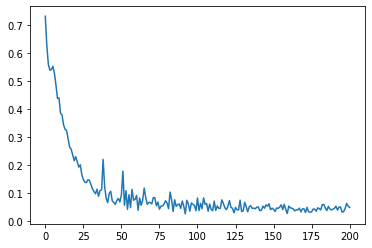

In [84]:
plt.plot(losses)

In [85]:
def test(model, tstx, tsty):
    with torch.no_grad():
    
        preds=torch.sigmoid(model(tstx)).round()
        print('testing report:')
        print(classification_report(preds.view(preds.shape[0]), tsty))
        print(torch.sigmoid(preds).round().shape)

In [86]:
tstx=torch.from_numpy(x_train[600:]).float()
tsty=torch.from_numpy(y_train[600:]).float()
test(model, tstx, tsty)

testing report:
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        49
         1.0       0.98      0.96      0.97       107

    accuracy                           0.96       156
   macro avg       0.95      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156

torch.Size([156, 1])


In [87]:
def run_network(model, trainx,trainy, testx, testy):
    model=Model()
    criterion = nn.BCEWithLogitsLoss()
    #optimizer=torch.optim.SGD(model.parameters(),lr=0.6,momentum=0.99, nesterov=True)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=.23)
    model, losses= train(model,optimizer, scheduler, criterion,trainx, trainy)
    test(model, testx, testy)
    
    return model, losses

In [88]:
fold=0
losses=[[] for i in range(10)]

for trids, tstids in k_fold.split(x_train):
    trainx, testx=x_train[trids,:], x_train[tstids,:]
    #trainx, testx=x_train[trids,:], x_train[tstids,:]
    trainy, testy=y_train[trids], y_train[tstids]
    
    trainx=torch.from_numpy(trainx).float()
    trainy=torch.from_numpy(trainy).float()
    testx=torch.from_numpy(testx).float()
    testy=torch.from_numpy(testy).float()
    
    print('fold: ',fold)
    
    model=Model()
    
    _,losses[fold]=run_network(model, trainx,trainy, testx,testy)
    
    fold=fold+1




fold:  0

training report: 
               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       165
         1.0       0.99      0.97      0.98       515

    accuracy                           0.97       680
   macro avg       0.95      0.97      0.96       680
weighted avg       0.97      0.97      0.97       680

testing report:
              precision    recall  f1-score   support

         0.0       0.43      0.60      0.50        10
         1.0       0.94      0.88      0.91        66

    accuracy                           0.84        76
   macro avg       0.68      0.74      0.70        76
weighted avg       0.87      0.84      0.85        76

torch.Size([76, 1])
fold:  1

training report: 
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       164
         1.0       1.00      0.98      0.99       516

    accuracy                           0.99       680
   macro avg       0.97      0.99 

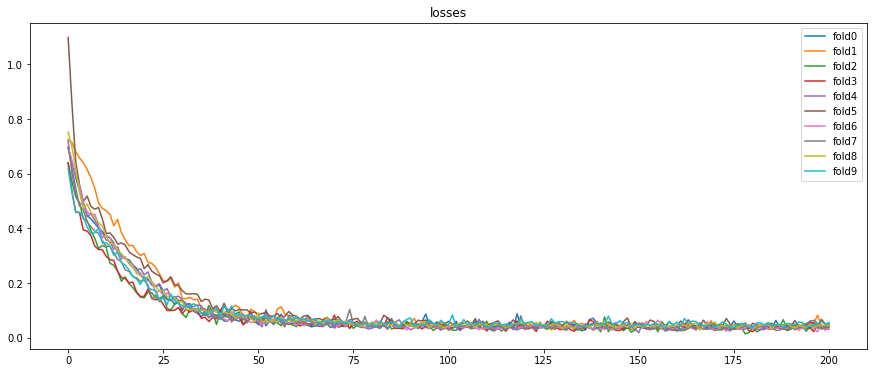

In [89]:

plt.figure(figsize=(15,6))
for i in range(10):
  plt.plot(losses[i],label='fold'+str(i))
plt.title('losses')
plt.legend(loc='upper_right')
#plt.ylim(0.0,2)

(0.2, 0.8)

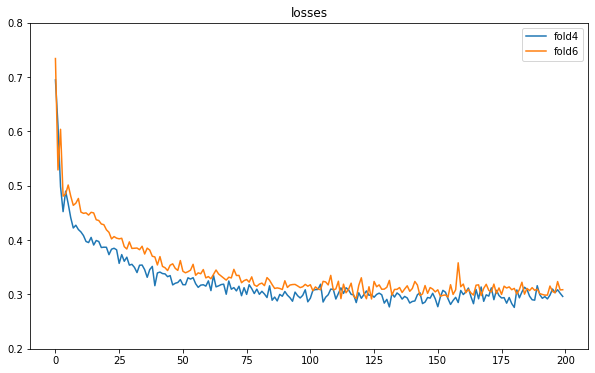

In [ ]:

plt.figure(figsize=(10,6))
for i in [4,6]:
  plt.plot(losses[i],label='fold'+str(i))
plt.title('losses')
plt.legend(loc='upper_right')
plt.ylim(0.2,.8)